Loading data...
Training set: (4755, 3009)
Test set: (1189, 3009)
Class distribution - Train: label
0    4020
1     735
Name: count, dtype: int64
Class distribution - Test: label
0    1005
1     184
Name: count, dtype: int64

TRAINING MODELS WITHOUT SMOTE
Training Random Forest without SMOTE...
Training XGBoost without SMOTE...

TRAINING MODELS WITH SMOTE
After SMOTE - Training set: (8040, 3009)
After SMOTE - Class distribution: label
1    4020
0    4020
Name: count, dtype: int64
Training Random Forest with SMOTE...
Training XGBoost with SMOTE...

COMPREHENSIVE MODEL COMPARISON

🔹 WITHOUT SMOTE:

📊 Random Forest (No SMOTE) Results:
Accuracy:    0.9756
Precision:   0.9480
Recall:      0.8913
F1-Score:    0.9188
AUC-ROC:     0.9903
False Positive Rate: 0.0090
False Negative Rate: 0.1087

Confusion Matrix:
[[996   9]
 [ 20 164]]

📊 XGBoost (No SMOTE) Results:
Accuracy:    0.9807
Precision:   0.9653
Recall:      0.9076
F1-Score:    0.9356
AUC-ROC:     0.9939
False Positive Rate: 0.0060
Fal

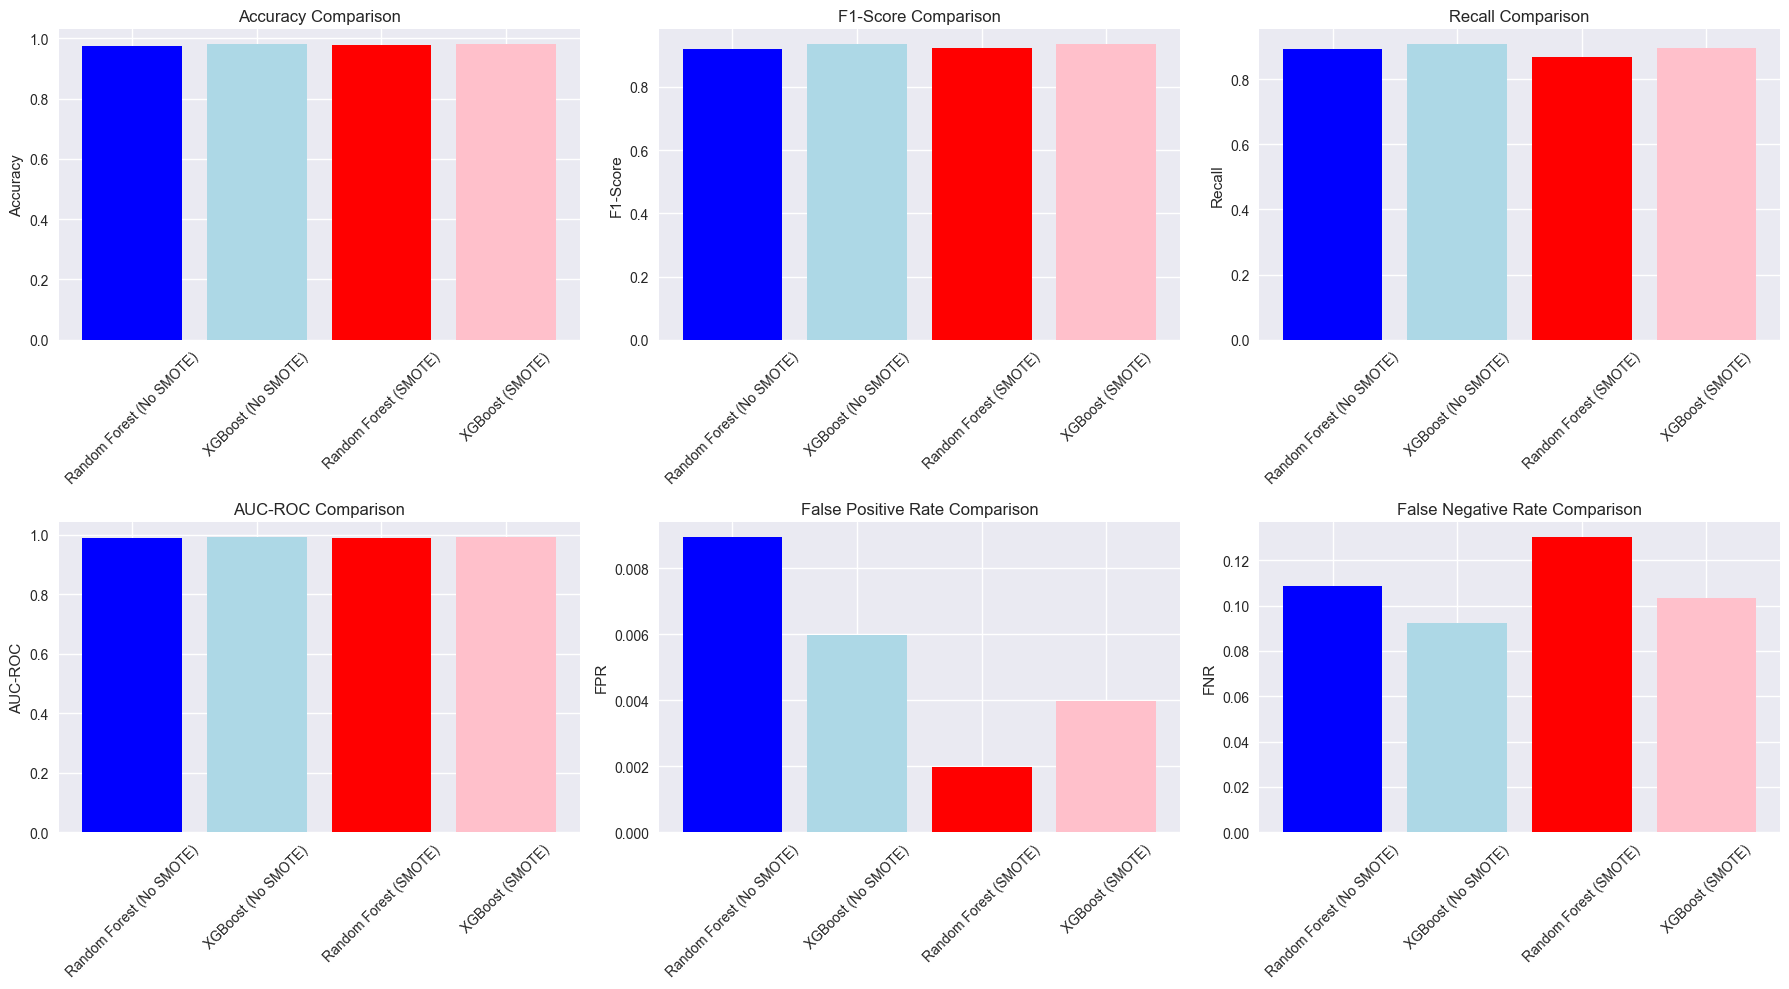


CROSS-VALIDATION COMPARISON
F1-Score Cross-Validation Results:
RF No SMOTE:  0.9350 (+/- 0.0283)
XGB No SMOTE: 0.9446 (+/- 0.0370)
RF SMOTE:     0.9809 (+/- 0.0312)
XGB SMOTE:    0.9894 (+/- 0.0283)

CONFUSION MATRIX VISUALIZATION


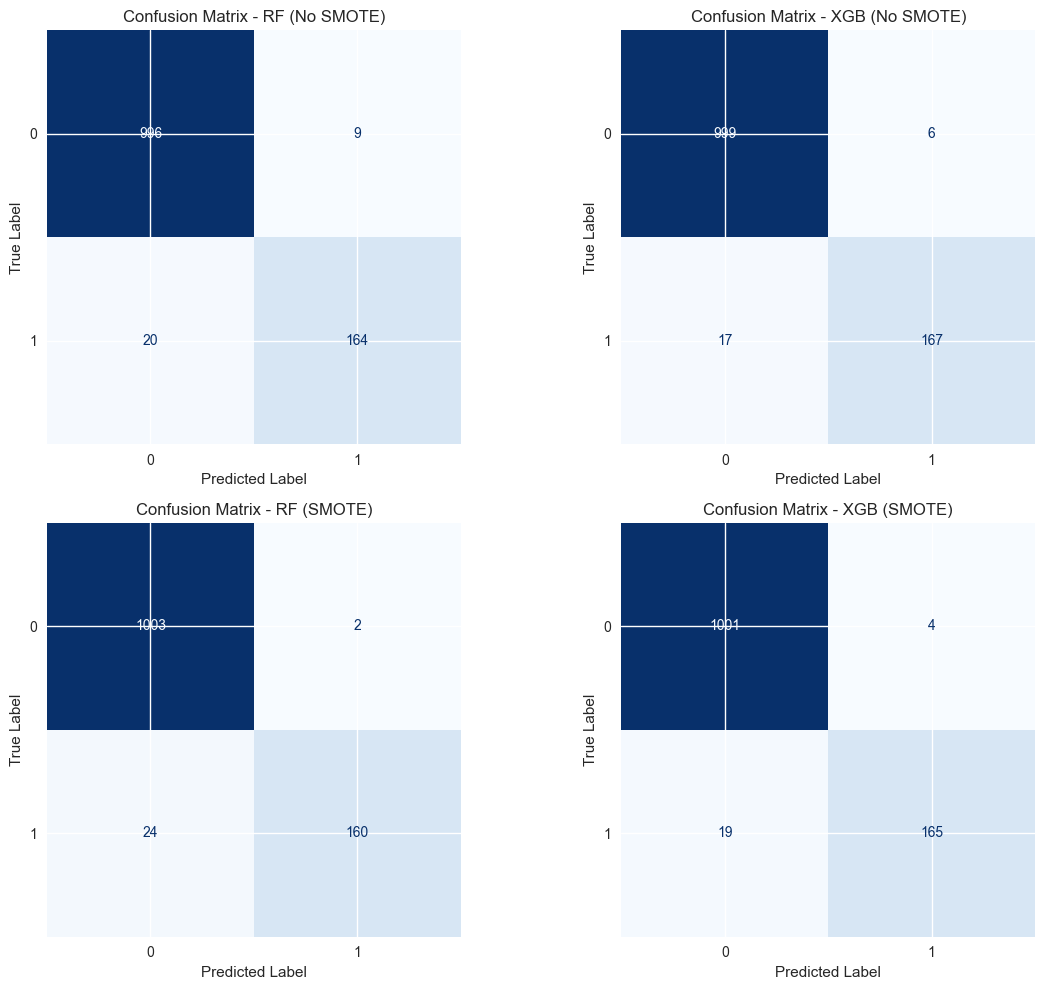

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load Data
print("Loading data...")
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')['label']
y_test = pd.read_csv('y_test.csv')['label']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {y_train.value_counts()}")
print(f"Class distribution - Test: {y_test.value_counts()}")

# Cell 3: Models WITHOUT SMOTE (Original Imbalanced Data)
print("\n" + "="*60)
print("TRAINING MODELS WITHOUT SMOTE")
print("="*60)

# Random Forest without SMOTE
rf_no_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Use class weights instead of SMOTE
    random_state=42,
    n_jobs=-1
)

# XGBoost without SMOTE
xgb_no_smote = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Handle imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Training Random Forest without SMOTE...")
rf_no_smote.fit(X_train, y_train)
rf_no_smote_pred = rf_no_smote.predict(X_test)
rf_no_smote_proba = rf_no_smote.predict_proba(X_test)[:, 1]

print("Training XGBoost without SMOTE...")
xgb_no_smote.fit(X_train, y_train)
xgb_no_smote_pred = xgb_no_smote.predict(X_test)
xgb_no_smote_proba = xgb_no_smote.predict_proba(X_test)[:, 1]

# Models WITH SMOTE (Your Previous Approach)
print("\n" + "="*60)
print("TRAINING MODELS WITH SMOTE")
print("="*60)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Training set: {X_train_smote.shape}")
print(f"After SMOTE - Class distribution: {pd.Series(y_train_smote).value_counts()}")

# Random Forest with SMOTE
rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,  # No class weights needed with balanced data
    n_jobs=-1
)

# XGBoost with SMOTE
xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,  # No scale_pos_weight needed with balanced data
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Training Random Forest with SMOTE...")
rf_smote.fit(X_train_smote, y_train_smote)
rf_smote_pred = rf_smote.predict(X_test)
rf_smote_proba = rf_smote.predict_proba(X_test)[:, 1]

print("Training XGBoost with SMOTE...")
xgb_smote.fit(X_train_smote, y_train_smote)
xgb_smote_pred = xgb_smote.predict(X_test)
xgb_smote_proba = xgb_smote.predict_proba(X_test)[:, 1]

# Comprehensive Evaluation Function
def evaluate_comprehensive(y_true, y_pred, y_proba, model_name):
    """Comprehensive evaluation with all metrics"""
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    # Additional business metrics
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # False positive rate (important for user experience)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # False negative rate (missed smishing - security risk)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}") 
    print(f"F1-Score:    {f1:.4f}")
    print(f"AUC-ROC:     {auc_roc:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1_score': f1, 'auc_roc': auc_roc, 'fpr': fpr, 'fnr': fnr
    }

# Evaluate All Models
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Evaluate without SMOTE
print("\n🔹 WITHOUT SMOTE:")
rf_no_smote_metrics = evaluate_comprehensive(y_test, rf_no_smote_pred, rf_no_smote_proba, "Random Forest (No SMOTE)")
xgb_no_smote_metrics = evaluate_comprehensive(y_test, xgb_no_smote_pred, xgb_no_smote_proba, "XGBoost (No SMOTE)")

print("\n🔹 WITH SMOTE:")
rf_smote_metrics = evaluate_comprehensive(y_test, rf_smote_pred, rf_smote_proba, "Random Forest (SMOTE)")
xgb_smote_metrics = evaluate_comprehensive(y_test, xgb_smote_pred, xgb_smote_proba, "XGBoost (SMOTE)")

# Comparison DataFrame
comparison_data = {
    'Random Forest (No SMOTE)': rf_no_smote_metrics,
    'XGBoost (No SMOTE)': xgb_no_smote_metrics,
    'Random Forest (SMOTE)': rf_smote_metrics,
    'XGBoost (SMOTE)': xgb_smote_metrics
}

comparison_df = pd.DataFrame(comparison_data).T
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
print(comparison_df.round(4))

# Cell 8: Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy comparison
models_names = list(comparison_data.keys())
accuracy_scores = [comparison_data[model]['accuracy'] for model in models_names]
axes[0,0].bar(models_names, accuracy_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score comparison
f1_scores = [comparison_data[model]['f1_score'] for model in models_names]
axes[0,1].bar(models_names, f1_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[0,1].set_title('F1-Score Comparison')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# Recall comparison
recall_scores = [comparison_data[model]['recall'] for model in models_names]
axes[0,2].bar(models_names, recall_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[0,2].set_title('Recall Comparison')
axes[0,2].set_ylabel('Recall')
axes[0,2].tick_params(axis='x', rotation=45)

# AUC-ROC comparison
auc_scores = [comparison_data[model]['auc_roc'] for model in models_names]
axes[1,0].bar(models_names, auc_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[1,0].set_title('AUC-ROC Comparison')
axes[1,0].set_ylabel('AUC-ROC')
axes[1,0].tick_params(axis='x', rotation=45)

# False Positive Rate comparison
fpr_scores = [comparison_data[model]['fpr'] for model in models_names]
axes[1,1].bar(models_names, fpr_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[1,1].set_title('False Positive Rate Comparison')
axes[1,1].set_ylabel('FPR')
axes[1,1].tick_params(axis='x', rotation=45)

# False Negative Rate comparison
fnr_scores = [comparison_data[model]['fnr'] for model in models_names]
axes[1,2].bar(models_names, fnr_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[1,2].set_title('False Negative Rate Comparison')
axes[1,2].set_ylabel('FNR')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Cross-Validation Comparison
print("\n" + "="*70)
print("CROSS-VALIDATION COMPARISON")
print("="*70)

# 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Without SMOTE
rf_no_smote_cv = cross_val_score(rf_no_smote, X_train, y_train, cv=cv, scoring='f1')
xgb_no_smote_cv = cross_val_score(xgb_no_smote, X_train, y_train, cv=cv, scoring='f1')

# With SMOTE (need to use SMOTE data)
rf_smote_cv = cross_val_score(rf_smote, X_train_smote, y_train_smote, cv=5, scoring='f1')
xgb_smote_cv = cross_val_score(xgb_smote, X_train_smote, y_train_smote, cv=5, scoring='f1')

print("F1-Score Cross-Validation Results:")
print(f"RF No SMOTE:  {rf_no_smote_cv.mean():.4f} (+/- {rf_no_smote_cv.std() * 2:.4f})")
print(f"XGB No SMOTE: {xgb_no_smote_cv.mean():.4f} (+/- {xgb_no_smote_cv.std() * 2:.4f})")
print(f"RF SMOTE:     {rf_smote_cv.mean():.4f} (+/- {rf_smote_cv.std() * 2:.4f})")
print(f"XGB SMOTE:    {xgb_smote_cv.mean():.4f} (+/- {xgb_smote_cv.std() * 2:.4f})")


# Confusion Matrix Visualization for All Models

from sklearn.metrics import ConfusionMatrixDisplay

print("\n" + "="*70)
print("CONFUSION MATRIX VISUALIZATION")
print("="*70)

models = {
    "RF (No SMOTE)": (y_test, rf_no_smote_pred),
    "XGB (No SMOTE)": (y_test, xgb_no_smote_pred),
    "RF (SMOTE)": (y_test, rf_smote_pred),
    "XGB (SMOTE)": (y_test, xgb_smote_pred)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (model_name, (y_true, y_pred)) in zip(axes, models.items()):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


